# Summary and test of changes in the PR: `NCDM->DR Perturbations`

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from time import time
from classy import Class
font = {'size'   : 22}
matplotlib.rc("font", **font)
matplotlib.rc(["text.usetex", True])

In [2]:
omega_g = 2.47298e-5  # Always this unless explicitly changed
omega_dncdmdr = (0.0 + 0.5)*7/8*(4/11)**(4/3)*omega_g # This values ensures a contribution DeltaNeff=0.5 today
Mpc_over_m = 3.085677581282e22
c          = 2.99792458e+8
k_B        = 1.38065e-23
eV         = 1.602e-19 # 1 eV in Joule
T_cmb      = 2.7254
T0         = (4/11)**(1/3)

def log10lifetime_to_Gamma(log10t):
    lifetime = 10**log10t
    return 1/lifetime/(365*24*60*60)*Mpc_over_m*1e-3

def get_spectrum(class_instance, lensing=True):
    if lensing:
        cls  = class_instance.lensed_cl(2500)
    else:
        cls  = class_instance.raw_cl(2500)
    ll   = cls['ell'][2:]
    clTT = cls['tt'][2:]
    cl   = clTT*ll*(ll+1)/2./np.pi
    return ll, cl

In [3]:
perts = {}
k_plot   = 0.2 # k to plot perturbations for, in 1/Mpc
k_max    = 1.0
l_max_dr = 5
LCDM_settings = {
    'output'           : 'tCl, lCl, mPk',
    'lensing'          : 'yes',
    'k_output_values'  : k_plot,
    'P_k_max_1/Mpc'    : k_max,
    'background_method': 0,
    'evolver'          : 1,

    'omega_b'          : 0.02238280,
    'omega_cdm'        : 0.1201075,
    'omega_g'          : omega_g,
    'N_eff'            : 3.046,
    'YHe'              : 0.2454006,
    'tau_reio'         : 0.05430842,
    'n_s'              : 0.9660499,
    'A_s'              : 2.100549e-09
}
dncdm_basic = {
    'omega_dncdmdr'     : omega_dncdmdr,
    'background_method' : 0,
    'N_ncdm_decay_dr'   : 1,
    'quadrature_strategy_ncdm_decay_dr': 3,
    'maximum_q_ncdm_decay_dr'          : 15,
    'N_momentum_bins_ncdm_decay_dr'    : 5,
    'l_max_dr'                         : l_max_dr,
    'l_max_ncdm'                       : 17, # default
    'ncdm_fluid_approximation'         : 3
}

single_species_models = [{
        'm_ncdm_decay_dr':10.0, # virker
        'Gamma_ncdm_decay_dr':1e+8
    }
]

LCDM = Class(LCDM_settings).compute()
ll_lcdm, cl_lcdm = get_spectrum(LCDM)

for idx, model in enumerate(single_species_models):
#    t = LCDM_settings | dncdm_basic | model
#    for key, val in t.items():
#        print(key, ' = ', val)
    begin_time = time()
    perts[idx] = Class(LCDM_settings | dncdm_basic | model).compute()
    print(f"Finished one computation in {time() - begin_time:.3} seconds.")
print("Class finished all computations!")

Finished one computation in 6.89 seconds.
Class finished all computations!


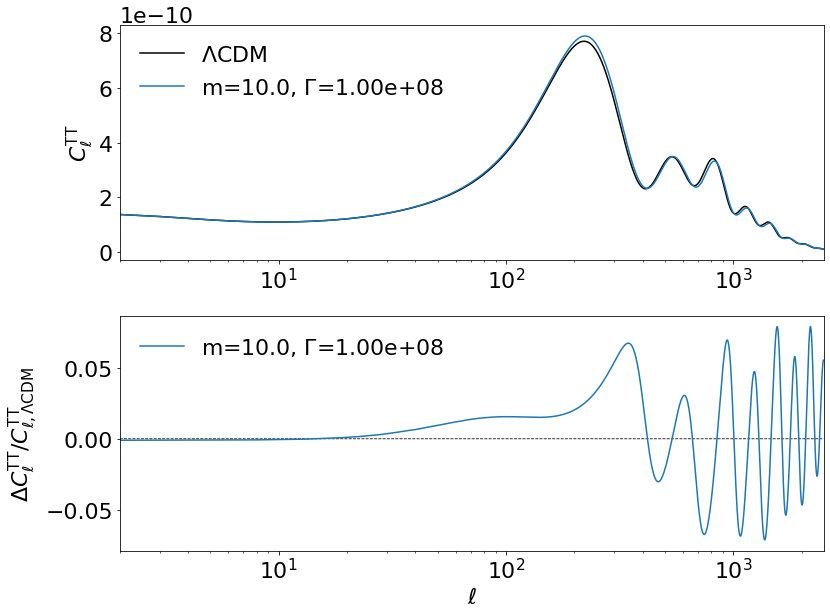

In [4]:
fig, ax = plt.subplots(2,1, figsize=[12, 9])
ax[0].set_xscale('log')
ax[0].set_yscale('linear')
ax[0].set_xlim(2,2500)
ax[0].set_ylabel(r'$C_\ell^{\mathrm{TT}}$')
ax[0].plot(ll_lcdm, cl_lcdm, 'k-', label=r'$\Lambda$CDM')
for idx, model in enumerate(single_species_models):
    ll, cl = get_spectrum(perts[idx])
    ax[0].plot(ll, cl, '-', label=f"m={model['m_ncdm_decay_dr']:.3}, $\Gamma$={model['Gamma_ncdm_decay_dr']:.2e}")
ax[0].legend(frameon=False)
ax[1].set_ylabel(r'$\Delta C_{\ell}^{\mathrm{TT}}/C_{\ell,\Lambda\mathrm{CDM}}^{\mathrm{TT}}$')
ax[1].set_xlabel(r'$\ell$')
ax[1].set_xscale('log')
ax[1].set_yscale('linear')
ax[1].set_xlim(2,2500)
ax[1].plot(ll_lcdm, np.zeros(len(ll_lcdm)), 'k--', lw=0.8)
for idx, model in enumerate(single_species_models):
    ll, cl = get_spectrum(perts[idx])
    ax[1].plot(ll, (cl - cl_lcdm)/cl_lcdm, '-', label=f"m={model['m_ncdm_decay_dr']:.3}, $\Gamma$={model['Gamma_ncdm_decay_dr']:.2e}")
ax[1].legend(frameon=False)
fig.tight_layout()

### Current bugs
* Perturbations do not run with $\theta_s$ specified, e.g. by adding ``'100*theta_s': 1.042143 `` to `LCDM_settings`.
* Gamma=0 seems to bug the perturbations. It works with small $\Gamma \gtrsim 1000$, but runs very slowly!
* background_method = 1 bugs out.
* The following output does not run: 
``
{'m_ncdm_decay_dr':10.0, 'Gamma_ncdm_decay_dr':1e+12}
``

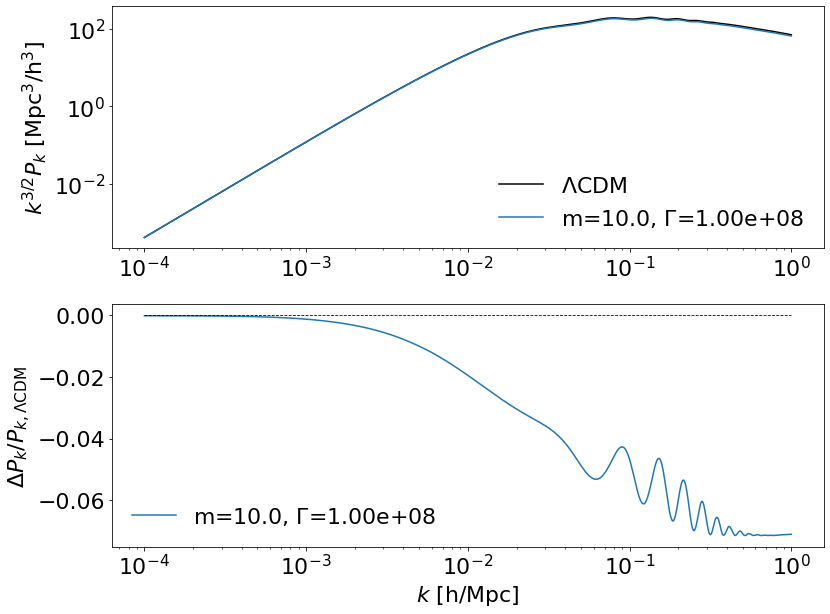

In [5]:
# Matter power spectrum
kk = np.logspace(-4,np.log10(k_max),1000) # k in h/Mpc
pk = []

fig, ax = plt.subplots(2,1, figsize=[12, 9])
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_ylabel(r'$k^{3/2} P_k$ [Mpc$^3$/h$^3$]')
pk_lcdm = np.array([LCDM.pk(k*LCDM.h(), 0.)*LCDM.h()**3 for k in kk])
ax[0].plot(kk, kk**(3/2)*pk_lcdm, 'k-', label=r'$\Lambda$CDM')
for idx, model in enumerate(single_species_models):
    ax[0].plot(kk, [k**(3/2)*perts[idx].pk(k*perts[idx].h(), 0.)*perts[idx].h()**3 for k in kk], '-', label=f"m={model['m_ncdm_decay_dr']:.3}, $\Gamma$={model['Gamma_ncdm_decay_dr']:.2e}")
ax[0].legend(frameon=False)
ax[1].set_ylabel(r'$\Delta P_k/P_{k,\Lambda\mathrm{CDM}}$')
ax[1].set_xlabel(r'$k$ [h/Mpc]')
ax[1].set_xscale('log')
ax[1].set_yscale('linear')
for idx, model in enumerate(single_species_models):
    pk = np.array([perts[idx].pk(k*perts[idx].h(), 0.)*perts[idx].h()**3 for k in kk])
    ax[1].plot(kk, (pk - pk_lcdm)/pk_lcdm, '-', label=f"m={model['m_ncdm_decay_dr']:.3}, $\Gamma$={model['Gamma_ncdm_decay_dr']:.2e}")
ax[1].plot(kk, np.zeros(len(kk)), 'k--', lw=0.8)
ax[1].legend(frameon=False)
fig.tight_layout()

In [6]:
def get_dr_perturbations(class_instance, dr_id, k, masses=None, Gammas=None, dcdm_offset=0):
    bg, perts = class_instance.get_background(), class_instance.get_perturbations()['scalar'][0]
    F_dr = []
    for i in range(l_max_dr):
        F_l = perts[f"F_dr[{dr_id + dcdm_offset}][{i}]"]
        F_dr.append(F_l)
    from scipy.interpolate import interp1d
    a_bg = 1/(1 + bg['z'])
    r_dr = bg[f'(.)rho_dr[{dr_id + dcdm_offset}]']*a_bg**4/bg['(.)rho_crit'][-1]
    r_dr_at_a = interp1d(a_bg, r_dr)
    M = masses[dr_id]*eV/k_B/T_cmb if masses != None else class_instance.pars['m_ncdm_decay_dr']*eV/k_B/T_cmb
    G = Gammas[dr_id]*1000/c if masses != None else class_instance.pars['Gamma_ncdm_decay_dr']*1000/c
    rprime_dr = 2*r_dr*a_bg*M*G*bg[f'(.)number_ncdm[{dr_id}]']/bg[f'(.)rho_dr[{dr_id + dcdm_offset}]']
    rprime_dr_at_a = interp1d(a_bg, rprime_dr)
    delta_dr = F_dr[0]/r_dr_at_a(perts['a'])
    theta_dr = 3*k/4*F_dr[1]/r_dr_at_a(perts['a'])
    return perts['tau [Mpc]'], delta_dr, theta_dr

/var/folders/zr/zbvzsdtx4kzb3_fpksfqd3xx5jyp_x/T/ipykernel_25071/1034131875.py:13: RuntimeWarning: invalid value encountered in true_divide
  rprime_dr = 2*r_dr*a_bg*M*G*bg[f'(.)number_ncdm[{dr_id}]']/bg[f'(.)rho_dr[{dr_id + dcdm_offset}]']


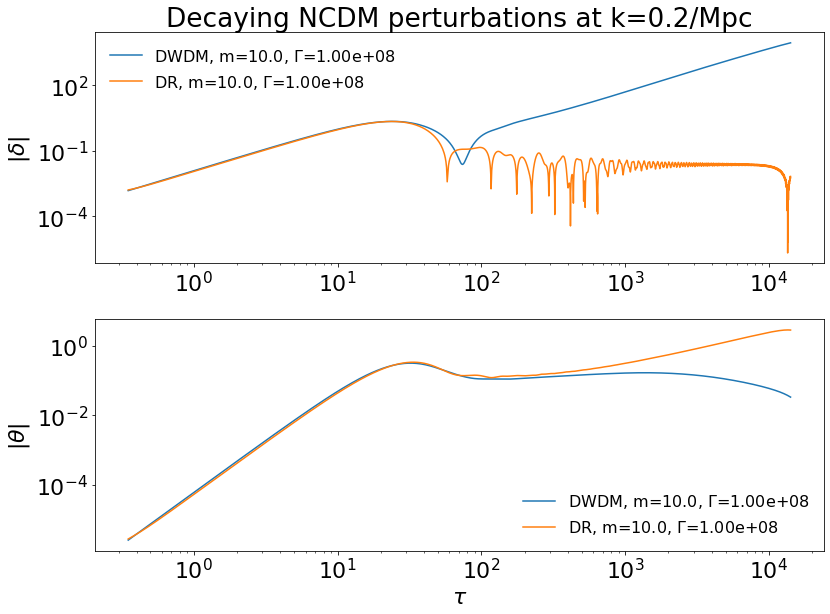

In [7]:
fig, ax = plt.subplots(2,1, figsize=[12, 9])
ax[0].set_title(f'Decaying NCDM perturbations at k={k_plot}/Mpc')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_ylabel(r'$|\delta|$')
# ax[0].set_xlabel(r'$k \tau$')
for idx, model in enumerate(single_species_models):
    pert = perts[idx].get_perturbations()['scalar'][0]
    tau_dr, delta_dr, theta_dr = get_dr_perturbations(perts[idx], 0, k_plot)
    ax[0].plot(pert['tau [Mpc]'], np.abs(pert['delta_ncdm[0]']), '-', label=f"DWDM, m={model['m_ncdm_decay_dr']:.3}, $\Gamma$={model['Gamma_ncdm_decay_dr']:.2e}")
    ax[1].plot(pert['tau [Mpc]'], np.abs(pert['theta_ncdm[0]']), '-', label=f"DWDM, m={model['m_ncdm_decay_dr']:.3}, $\Gamma$={model['Gamma_ncdm_decay_dr']:.2e}")
    ax[0].plot(tau_dr, np.abs(delta_dr), '-', label=f"DR, m={model['m_ncdm_decay_dr']:.3}, $\Gamma$={model['Gamma_ncdm_decay_dr']:.2e}")
    ax[1].plot(tau_dr, np.abs(theta_dr), '-', label=f"DR, m={model['m_ncdm_decay_dr']:.3}, $\Gamma$={model['Gamma_ncdm_decay_dr']:.2e}")
ax[0].legend(frameon=False, fontsize=16)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_ylabel(r'$|\theta|$')
ax[1].set_xlabel(r'$\tau$')
ax[1].legend(frameon=False, fontsize=16)
fig.tight_layout()

Apparently, there is a plotting bug with $\theta$ for small masses. This is probably because the decay occurs so nonuniformly across the bins that one cannot renormalize the fraction when computing $\theta$!

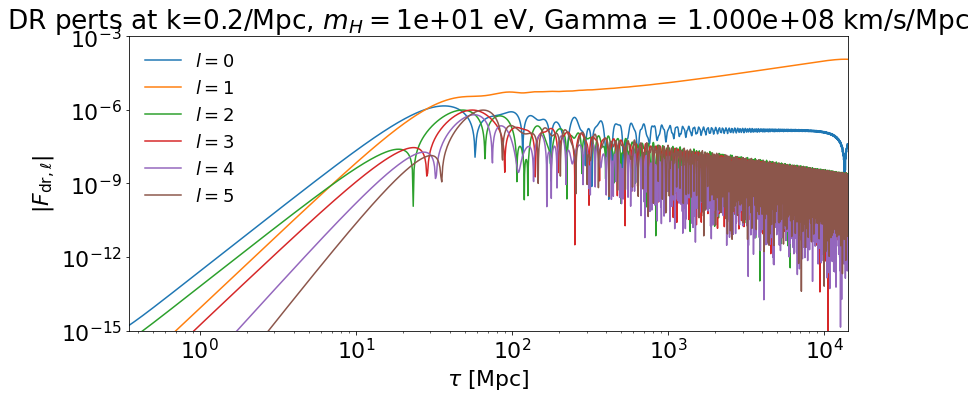

In [8]:
idx_plot = 0
pert = perts[idx_plot].get_perturbations()['scalar'][0]
fig, ax = plt.subplots(1, 1, figsize=[12, 6])
plt.title(f"DR perts at k={k_plot}/Mpc, $m_H=${single_species_models[idx_plot]['m_ncdm_decay_dr']:.2} eV, Gamma = {single_species_models[idx_plot]['Gamma_ncdm_decay_dr']:.3e} km/s/Mpc")
ax.set(xscale='log', yscale='log', xlabel=r'$\tau$ [Mpc]', ylabel=r'$|F_{\mathrm{dr},\ell}|$')
l_max_plot_dr = 6
for l in range(l_max_plot_dr):
    ax.plot(pert['tau [Mpc]'], np.abs(pert[f'F_dr[0][{l}]']), label=r'$l=$'+str(l))
ax.set_ylim([1e-15, 1e-3])
ax.set_xlim([min(pert['tau [Mpc]']), max(pert['tau [Mpc]'])])
ax.legend(frameon=False, fontsize=18)
fig.tight_layout()

## Multiple decaying species

In [9]:
masses = [1.0, 5.0, 10.0]
Gammas = [1e+8, 1e+7, 1e+8]
Omegas = [5e-4, 1e-4, 1e-5]
multiple_decaying_ncdm = {
    'N_ncdm_decay_dr'    : 3,
    'm_ncdm_decay_dr'    : ', '.join([str(mass) for mass in masses]),
    'Gamma_ncdm_decay_dr': ', '.join([str(Gamma) for Gamma in Gammas]),
    'Omega_dncdmdr'      : ', '.join([str(Omega) for Omega in Omegas]),
    'quadrature_strategy_ncdm_decay_dr': '3, 3, 3',
    'l_max_dr'                         : '5, 7, 9',
    'N_momentum_bins_ncdm_decay_dr'    : '5, 8, 11',
    'ncdm_fluid_approximation'         : '3, 3, 3'
}
begin = time()
multiple = Class(LCDM_settings | multiple_decaying_ncdm).compute()
print(f"Finished computation in {time() - begin:.3} seconds.")

Finished computation in 33.8 seconds.


/var/folders/zr/zbvzsdtx4kzb3_fpksfqd3xx5jyp_x/T/ipykernel_25071/1034131875.py:13: RuntimeWarning: invalid value encountered in true_divide
  rprime_dr = 2*r_dr*a_bg*M*G*bg[f'(.)number_ncdm[{dr_id}]']/bg[f'(.)rho_dr[{dr_id + dcdm_offset}]']
/var/folders/zr/zbvzsdtx4kzb3_fpksfqd3xx5jyp_x/T/ipykernel_25071/1034131875.py:13: RuntimeWarning: invalid value encountered in true_divide
  rprime_dr = 2*r_dr*a_bg*M*G*bg[f'(.)number_ncdm[{dr_id}]']/bg[f'(.)rho_dr[{dr_id + dcdm_offset}]']
/var/folders/zr/zbvzsdtx4kzb3_fpksfqd3xx5jyp_x/T/ipykernel_25071/1034131875.py:13: RuntimeWarning: invalid value encountered in true_divide
  rprime_dr = 2*r_dr*a_bg*M*G*bg[f'(.)number_ncdm[{dr_id}]']/bg[f'(.)rho_dr[{dr_id + dcdm_offset}]']


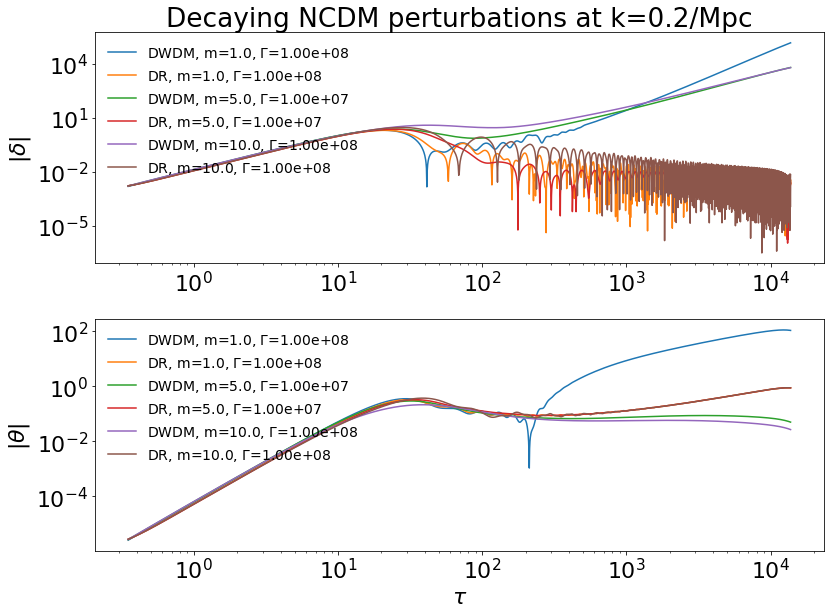

In [10]:
fig, ax = plt.subplots(2,1, figsize=[12, 9])
ax[0].set_title(f'Decaying NCDM perturbations at k={k_plot}/Mpc')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_ylabel(r'$|\delta|$')
# ax[0].set_xlabel(r'$k \tau$')
for idx in range(3):
    pert = multiple.get_perturbations()['scalar'][0]
    tau_dr, delta_dr, theta_dr = get_dr_perturbations(multiple, idx, k_plot, masses, Gammas)
    ax[0].plot(pert['tau [Mpc]'], np.abs(pert[f'delta_ncdm[{idx}]']), '-', label=f"DWDM, m={masses[idx]:.3}, $\Gamma$={Gammas[idx]:.2e}")
    ax[1].plot(pert['tau [Mpc]'], np.abs(pert[f'theta_ncdm[{idx}]']), '-', label=f"DWDM, m={masses[idx]:.3}, $\Gamma$={Gammas[idx]:.2e}")
    ax[0].plot(tau_dr, np.abs(delta_dr), '-', label=f"DR, m={masses[idx]:.3}, $\Gamma$={Gammas[idx]:.2e}")
    ax[1].plot(tau_dr, np.abs(theta_dr), '-', label=f"DR, m={masses[idx]:.3}, $\Gamma$={Gammas[idx]:.2e}")
ax[0].legend(frameon=False, fontsize=14)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_ylabel(r'$|\theta|$')
ax[1].set_xlabel(r'$\tau$')
ax[1].legend(frameon=False, fontsize=14)
fig.tight_layout()

## Both decaying and stable species simultaneously

In [11]:
masses = [1.0, 10.0]
Gammas = [1e+8, 1e+8]

with_stable = {
    'N_ncdm_standard'        : 2,
    'm_ncdm_standard'        : '10.0, 100.0',
    'Omega_ncdm_standard'    : '0.005, 0.005',
    
    'N_ncdm_decay_dr'        : 2,
    'm_ncdm_decay_dr'        : ', '.join([str(mass) for mass in masses]),
    'Gamma_ncdm_decay_dr'    : ', '.join([str(Gamma) for Gamma in Gammas]),
    'Omega_dncdmdr'          : '0.0005, 0.001',
    'quadrature_strategy_ncdm_decay_dr': '3, 3',
    'N_momentum_bins_ncdm_decay_dr'    : '5, 5',
    'ncdm_fluid_approximation'         : '3, 3'
}
begin = time()
stable = Class(LCDM_settings | with_stable).compute()
print(f"Finished computation in {time() - begin:.3} seconds.")

Finished computation in 26.2 seconds.


/var/folders/zr/zbvzsdtx4kzb3_fpksfqd3xx5jyp_x/T/ipykernel_25071/1034131875.py:13: RuntimeWarning: invalid value encountered in true_divide
  rprime_dr = 2*r_dr*a_bg*M*G*bg[f'(.)number_ncdm[{dr_id}]']/bg[f'(.)rho_dr[{dr_id + dcdm_offset}]']
/var/folders/zr/zbvzsdtx4kzb3_fpksfqd3xx5jyp_x/T/ipykernel_25071/1034131875.py:13: RuntimeWarning: invalid value encountered in true_divide
  rprime_dr = 2*r_dr*a_bg*M*G*bg[f'(.)number_ncdm[{dr_id}]']/bg[f'(.)rho_dr[{dr_id + dcdm_offset}]']


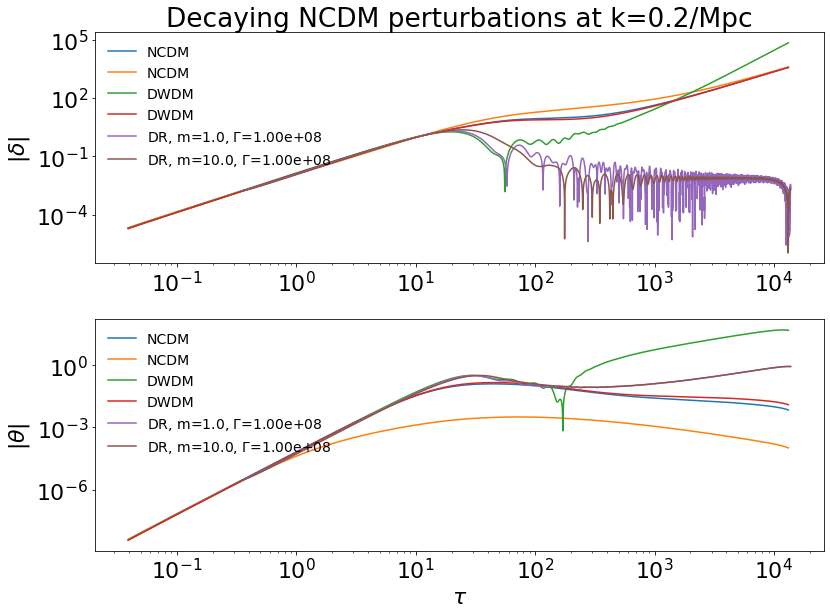

In [12]:
fig, ax = plt.subplots(2,1, figsize=[12, 9])
ax[0].set_title(f'Decaying NCDM perturbations at k={k_plot}/Mpc')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_ylabel(r'$|\delta|$')
# ax[0].set_xlabel(r'$k \tau$')

pert = stable.get_perturbations()['scalar'][0]
ax[0].plot(pert['tau [Mpc]'], np.abs(pert[f'delta_ncdm[0]']), '-', label=f"NCDM")
ax[1].plot(pert['tau [Mpc]'], np.abs(pert[f'theta_ncdm[0]']), '-', label=f"NCDM")
ax[0].plot(pert['tau [Mpc]'], np.abs(pert[f'delta_ncdm[1]']), '-', label=f"NCDM")
ax[1].plot(pert['tau [Mpc]'], np.abs(pert[f'theta_ncdm[1]']), '-', label=f"NCDM")
ax[0].plot(pert['tau [Mpc]'], np.abs(pert[f'delta_ncdm[2]']), '-', label=f"DWDM")
ax[1].plot(pert['tau [Mpc]'], np.abs(pert[f'theta_ncdm[2]']), '-', label=f"DWDM")
ax[0].plot(pert['tau [Mpc]'], np.abs(pert[f'delta_ncdm[3]']), '-', label=f"DWDM")
ax[1].plot(pert['tau [Mpc]'], np.abs(pert[f'theta_ncdm[3]']), '-', label=f"DWDM")
for idx in range(2):
    pert = stable.get_perturbations()['scalar'][0]
    tau_dr, delta_dr, theta_dr = get_dr_perturbations(multiple, idx, k_plot, masses, Gammas)
    ax[0].plot(tau_dr, np.abs(delta_dr), '-', label=f"DR, m={masses[idx]:.3}, $\Gamma$={Gammas[idx]:.2e}")
    ax[1].plot(tau_dr, np.abs(theta_dr), '-', label=f"DR, m={masses[idx]:.3}, $\Gamma$={Gammas[idx]:.2e}")
ax[0].legend(frameon=False, fontsize=14)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_ylabel(r'$|\theta|$')
ax[1].set_xlabel(r'$\tau$')
ax[1].legend(frameon=False, fontsize=14)
fig.tight_layout()

## Both decaying ncdm and dcdm simultaneously

In [13]:
masses = [1.0, 10.0]
Gammas = [1e+8, 1e+8]

with_dcdm = {
    'Omega_dcdmdr'           : 0.001,
    'Gamma_dcdm'             : 1e+8,
    
    'N_ncdm_decay_dr'        : 2,
    'm_ncdm_decay_dr'        : ', '.join([str(mass) for mass in masses]),
    'Gamma_ncdm_decay_dr'    : ', '.join([str(Gamma) for Gamma in Gammas]),
    'Omega_dncdmdr'          : '0.005, 0.005',
    'quadrature_strategy_ncdm_decay_dr': '3, 3',
    'N_momentum_bins_ncdm_decay_dr'    : '5, 5',
    'ncdm_fluid_approximation'         : '3, 3'
}
begin = time()
dcdm = Class(LCDM_settings | with_dcdm).compute()
print(f"Finished computation in {time() - begin:.3} seconds.")

Finished computation in 32.7 seconds.


/var/folders/zr/zbvzsdtx4kzb3_fpksfqd3xx5jyp_x/T/ipykernel_25071/1034131875.py:13: RuntimeWarning: invalid value encountered in true_divide
  rprime_dr = 2*r_dr*a_bg*M*G*bg[f'(.)number_ncdm[{dr_id}]']/bg[f'(.)rho_dr[{dr_id + dcdm_offset}]']


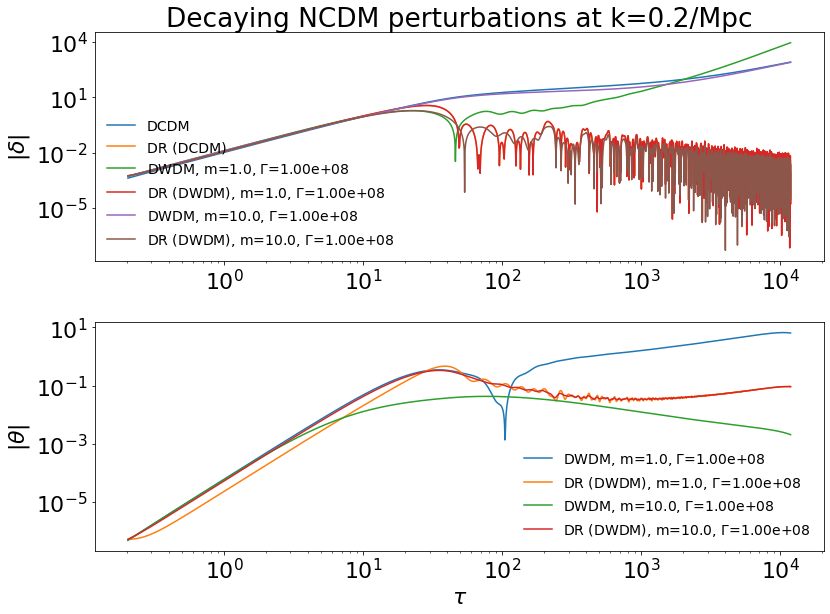

In [14]:
fig, ax = plt.subplots(2,1, figsize=[12, 9])
ax[0].set_title(f'Decaying NCDM perturbations at k={k_plot}/Mpc')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_ylabel(r'$|\delta|$')
# ax[0].set_xlabel(r'$k \tau$')
pert = dcdm.get_perturbations()['scalar'][0]
ax[0].plot(pert['tau [Mpc]'], np.abs(pert['delta_dcdm']), '-', label='DCDM')
ax[0].plot(pert['tau [Mpc]'], np.abs(pert['delta_dr[0]']), '-', label='DR (DCDM)')
for idx in range(2):
    tau_dr, delta_dr, theta_dr = get_dr_perturbations(dcdm, idx, k_plot, masses, Gammas)
    ax[0].plot(pert['tau [Mpc]'], np.abs(pert[f'delta_ncdm[{idx}]']), '-', label=f"DWDM, m={masses[idx]:.3}, $\Gamma$={Gammas[idx]:.2e}")
    ax[1].plot(pert['tau [Mpc]'], np.abs(pert[f'theta_ncdm[{idx}]']), '-', label=f"DWDM, m={masses[idx]:.3}, $\Gamma$={Gammas[idx]:.2e}")
    ax[0].plot(tau_dr, np.abs(delta_dr), '-', label=f"DR (DWDM), m={masses[idx]:.3}, $\Gamma$={Gammas[idx]:.2e}")
    ax[1].plot(tau_dr, np.abs(theta_dr), '-', label=f"DR (DWDM), m={masses[idx]:.3}, $\Gamma$={Gammas[idx]:.2e}")
ax[0].legend(frameon=False, fontsize=14)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_ylabel(r'$|\theta|$')
ax[1].set_xlabel(r'$\tau$')
ax[1].legend(frameon=False, fontsize=14)
fig.tight_layout()

## A model with ncdm, dcdm and multiple dncdm species!

In [15]:
big_model = {
    'N_ncdm_standard'        : 1,
    'm_ncdm_standard'        : 10.0,
    'Omega_ncdm_standard'    : 0.01,
    
    'Omega_dcdmdr'           : 0.01,
    'Gamma_dcdm'             : 1e+8,
    
    'N_ncdm_decay_dr'        : 2,
    'm_ncdm_decay_dr'        : '10.0, 10.0',
    'Gamma_ncdm_decay_dr'    : '1e+8, 1e+8',
    'Omega_dncdmdr'          : '0.001, 0.01',
    'quadrature_strategy_ncdm_decay_dr': '3, 3',
    'N_momentum_bins_ncdm_decay_dr'    : '5, 5',
    'ncdm_fluid_approximation'         : '3, 3'
}
begin = time()
big = Class(LCDM_settings | big_model).compute()
print(f"Finished computation in {time() - begin:.3} seconds.")

Finished computation in 38.7 seconds.


/var/folders/zr/zbvzsdtx4kzb3_fpksfqd3xx5jyp_x/T/ipykernel_25071/1034131875.py:13: RuntimeWarning: invalid value encountered in true_divide
  rprime_dr = 2*r_dr*a_bg*M*G*bg[f'(.)number_ncdm[{dr_id}]']/bg[f'(.)rho_dr[{dr_id + dcdm_offset}]']


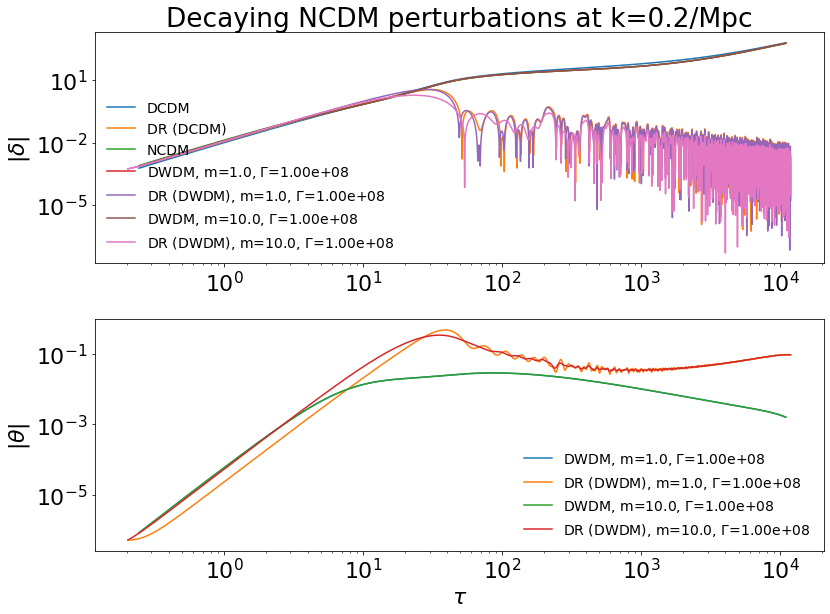

In [16]:
fig, ax = plt.subplots(2,1, figsize=[12, 9])
ax[0].set_title(f'Decaying NCDM perturbations at k={k_plot}/Mpc')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_ylabel(r'$|\delta|$')
pert = big.get_perturbations()['scalar'][0]
ax[0].plot(pert['tau [Mpc]'], np.abs(pert['delta_dcdm']), '-', label='DCDM')
ax[0].plot(pert['tau [Mpc]'], np.abs(pert['delta_dr[0]']), '-', label='DR (DCDM)')
ax[0].plot(pert['tau [Mpc]'], np.abs(pert[f'delta_ncdm[0]']), '-', label=f"NCDM")
for idx in [1, 2]:
    tau_dr, delta_dr, theta_dr = get_dr_perturbations(dcdm, idx-1, k_plot, masses, Gammas)
    ax[0].plot(pert['tau [Mpc]'], np.abs(pert[f'delta_ncdm[{idx}]']), '-', label=f"DWDM, m={masses[idx-1]:.3}, $\Gamma$={Gammas[idx-1]:.2e}")
    ax[1].plot(pert['tau [Mpc]'], np.abs(pert[f'theta_ncdm[{idx}]']), '-', label=f"DWDM, m={masses[idx-1]:.3}, $\Gamma$={Gammas[idx-1]:.2e}")
    ax[0].plot(tau_dr, np.abs(delta_dr), '-', label=f"DR (DWDM), m={masses[idx-1]:.3}, $\Gamma$={Gammas[idx-1]:.2e}")
    ax[1].plot(tau_dr, np.abs(theta_dr), '-', label=f"DR (DWDM), m={masses[idx-1]:.3}, $\Gamma$={Gammas[idx-1]:.2e}")
ax[0].legend(frameon=False, fontsize=14)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_ylabel(r'$|\theta|$')
ax[1].set_xlabel(r'$\tau$')
ax[1].legend(frameon=False, fontsize=14)
fig.tight_layout()

# Fluid approximation comparison

In [17]:
trigger = 64
fluid = Class(LCDM_settings | dncdm_basic | single_species_models[0] | {'ncdm_fluid_approximation':2, 'ncdm_fluid_trigger_tau_over_tau_k':trigger}).compute()
tau_fluid = fluid.get_perturbations()['scalar'][0]['tau [Mpc]']
trigger_id = np.argmin(np.abs(trigger - k_plot*tau_fluid))

/var/folders/zr/zbvzsdtx4kzb3_fpksfqd3xx5jyp_x/T/ipykernel_25071/1034131875.py:13: RuntimeWarning: invalid value encountered in true_divide
  rprime_dr = 2*r_dr*a_bg*M*G*bg[f'(.)number_ncdm[{dr_id}]']/bg[f'(.)rho_dr[{dr_id + dcdm_offset}]']
/var/folders/zr/zbvzsdtx4kzb3_fpksfqd3xx5jyp_x/T/ipykernel_25071/1034131875.py:13: RuntimeWarning: invalid value encountered in true_divide
  rprime_dr = 2*r_dr*a_bg*M*G*bg[f'(.)number_ncdm[{dr_id}]']/bg[f'(.)rho_dr[{dr_id + dcdm_offset}]']


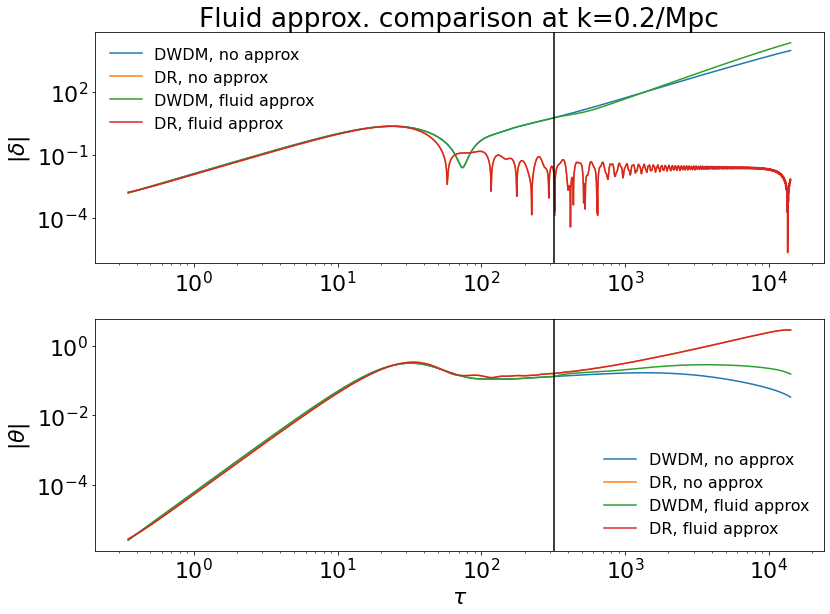

In [18]:
fig, ax = plt.subplots(2,1, figsize=[12, 9])
ax[0].set_title(f'Fluid approx. comparison at k={k_plot}/Mpc')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_ylabel(r'$|\delta|$')
# ax[0].set_xlabel(r'$k \tau$')
for idx, clas in enumerate([perts[0], fluid]):
    pert = clas.get_perturbations()['scalar'][0]
    tau_dr, delta_dr, theta_dr = get_dr_perturbations(clas, 0, k_plot)
    label = "no approx" if idx == 0 else "fluid approx"
    ax[0].plot(pert['tau [Mpc]'], np.abs(pert['delta_ncdm[0]']), '-', label=f"DWDM, "+label)
    ax[1].plot(pert['tau [Mpc]'], np.abs(pert['theta_ncdm[0]']), '-', label=f"DWDM, "+label)
    ax[0].plot(tau_dr, np.abs(delta_dr), '-', label=f"DR, "+label)
    ax[1].plot(tau_dr, np.abs(theta_dr), '-', label=f"DR, "+label)
ax[0].axvline(x=tau_fluid[trigger_id], color='k', linestyle='-')
ax[1].axvline(x=tau_fluid[trigger_id], color='k', linestyle='-')
ax[0].legend(frameon=False, fontsize=16)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_ylabel(r'$|\theta|$')
ax[1].set_xlabel(r'$\tau$')
ax[1].legend(frameon=False, fontsize=16)
fig.tight_layout()